[Tabluar Quickstart](https://auto.gluon.ai/stable/tutorials/tabular_prediction/tabular-quickstart.html) を参考にAutoGluonを使ってみる。

In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor

# データの読み込み
TabularDatasetはデータを読み込みpandasのDataFrameを返す

In [2]:
train_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,178478,Bachelors,13,Never-married,Tech-support,Own-child,White,Female,0,0,40,United-States,<=50K
1,23,State-gov,61743,5th-6th,3,Never-married,Transport-moving,Not-in-family,White,Male,0,0,35,United-States,<=50K
2,46,Private,376789,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,15,United-States,<=50K
3,55,?,200235,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,50,United-States,>50K
4,36,Private,224541,7th-8th,4,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,El-Salvador,<=50K


データが多いと学習に時間がかかるため、学習時に使うデータを500個に絞る

In [3]:
subsample_size = 500
train_data = train_data.sample(n=subsample_size, random_state=0)
train_data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,39.65200,189322.638000,10.118000,1040.906000,118.054000,40.802000
std,13.52393,94845.719575,2.582521,5462.912364,456.158416,12.168111
min,17.00000,22201.000000,2.000000,0.000000,0.000000,1.000000
25%,29.00000,129695.000000,9.000000,0.000000,0.000000,40.000000
50%,38.00000,183068.500000,10.000000,0.000000,0.000000,40.000000
75%,49.00000,230417.750000,13.000000,0.000000,0.000000,45.000000
max,85.00000,723746.000000,16.000000,99999.000000,2415.000000,99.000000


classというカラムに今回予測の対象となるラベルが含まれる。

In [4]:
label = 'class'
train_data[label]

6118       >50K
23204     <=50K
29590     <=50K
18116     <=50K
33964      >50K
          ...  
29128     <=50K
23950     <=50K
13700      >50K
35248     <=50K
24772     <=50K
Name: class, Length: 500, dtype: object

In [5]:
train_data[label].describe()

count        500
unique         2
top        <=50K
freq         365
Name: class, dtype: object

labelに含まれるデータを調査。今回は2値分類問題。
AutoGluonでは、どの問題を解こうとしているかを自動で判別してくれる。

In [6]:
train_data[label].value_counts()

 <=50K    365
 >50K     135
Name: class, dtype: int64

# 予測
AutoGluonは学習したモデルをファイルとして保存することができる。
保存先はTabuarPredictorのpathとして渡す。

予測には、labelを含むDataFrameをそのまま渡し、引数labelにlabelとなるカラムを渡す。
sklearnのように説明変数X, 目的変数yを渡すような構造ではない。

In [7]:
save_path = 'auto-gluon-models' 
predictor = TabularPredictor(label=label, path=save_path)

- fitを実行すると、データの基本情報などが抽出され、どの問題を解くかが表示される。
- Stageごとに何をやるかも表示される。
  1. 2値となっているカラムをbooleanに変換
  2. 欠損値を補完
  3. カテゴリタイプに変換。希少なカテゴリは削除し、メモリを節約
  4. ユニークな値が1つもしくは、ほとんどがユニークな値となるカテゴリしかないカラムを削除
- 学習データと検証データは自動的に分割
- このケースの場合13個のモデルで学習を行う
- それぞれの正解率と学習にかかった時間と検証にかかった時間を表示
- 最後に学習済みモデルを指定したフォルダに保存

In [8]:
predictor.fit(train_data) # 1回目のfit後、追加のデータで学習するときはfit_extraを使う

Beginning AutoGluon training ...
AutoGluon will save models to "auto-gluon-models/"
AutoGluon Version:  0.3.1
Train Data Rows:    500
Train Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [' >50K', ' <=50K']
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 =  >50K, class 0 =  <=50K
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive ( >50K) vs negative ( <=50K) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    15007.74 MB
	Train Dat

In [9]:
print(predictor.feature_metadata)

('category', [])  : 7 | ['workclass', 'education', 'marital-status', 'occupation', 'relationship', ...]
('int', [])       : 6 | ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', ...]
('int', ['bool']) : 1 | ['sex']


In [10]:
!tree $save_path

auto-gluon-models
├── learner.pkl
├── models
│   ├── CatBoost
│   │   └── model.pkl
│   ├── ExtraTreesEntr
│   │   └── model.pkl
│   ├── ExtraTreesGini
│   │   └── model.pkl
│   ├── KNeighborsDist
│   │   └── model.pkl
│   ├── KNeighborsUnif
│   │   └── model.pkl
│   ├── LightGBM
│   │   └── model.pkl
│   ├── LightGBMLarge
│   │   └── model.pkl
│   ├── LightGBMXT
│   │   └── model.pkl
│   ├── NeuralNetFastAI
│   │   ├── model-internals.pkl
│   │   └── model.pkl
│   ├── NeuralNetMXNet
│   │   ├── model.pkl
│   │   └── net.params
│   ├── RandomForestEntr
│   │   └── model.pkl
│   ├── RandomForestGini
│   │   └── model.pkl
│   ├── WeightedEnsemble_L2
│   │   ├── model.pkl
│   │   └── utils
│   │       ├── model_template.pkl
│   │       └── oof.pkl
│   ├── XGBoost
│   │   └── model.pkl
│   └── trainer.pkl
├── predictor.pkl
└── utils
    └── data
        ├── X.pkl
        ├── X_val.pkl
        ├── y.pkl
        └── y_val.pkl

18 directories, 25 files


# テスト
学習データの読み込みと同様にテストデータの読み込みTabularDatasetを使う。

In [11]:
test_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv')

Loaded data from: https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv | Columns = 15 / 15 | Rows = 9769 -> 9769


説明変数と目的変数を別々に分ける必要がある。

In [12]:
y_test = test_data[label]  # values to predict
test_data_nolab = test_data.drop(columns=[label])  # delete label column to prove we're not cheating
test_data_nolab.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,31,Private,169085,11th,7,Married-civ-spouse,Sales,Wife,White,Female,0,0,20,United-States
1,17,Self-emp-not-inc,226203,12th,8,Never-married,Sales,Own-child,White,Male,0,0,45,United-States
2,47,Private,54260,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,60,United-States
3,21,Private,176262,Some-college,10,Never-married,Exec-managerial,Own-child,White,Female,0,0,30,United-States
4,17,Private,241185,12th,8,Never-married,Prof-specialty,Own-child,White,Male,0,0,20,United-States


predictメソッドに説明変数を与えることで予測ができる。

このあたりは他の機械学習ライブラリと変わらないが、予測結果はpandasのSeriesで返ってくる (目的変数が1つの場合)。

In [13]:
y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)

Predictions:  
 0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
9764     <=50K
9765     <=50K
9766     <=50K
9767     <=50K
9768     <=50K
Name: class, Length: 9769, dtype: object


In [14]:
y_pred.value_counts()

 <=50K    7887
 >50K     1882
Name: class, dtype: int64

評価はevaluate_predictionsを使って行う。結果はdictで返される。

In [15]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred)

Evaluation: accuracy on test data: 0.8374449790152523
Evaluations on test data:
{
    "accuracy": 0.8374449790152523,
    "balanced_accuracy": 0.7430558394221018,
    "mcc": 0.5243657567117436,
    "f1": 0.621904761904762,
    "precision": 0.69394261424017,
    "recall": 0.5634167385677308
}


leaderboardでアルゴリズムそれぞれで予測した結果を見ることもできる。

`stack_level = N` は `stack_level = N-1` のモデルをインプットとして使うモデル。
`stack_level = 1` の場合、モデルをインプットとして使わない。

今回の場合、13個のモデルを `WeightedEnsemble_L2` のインプットとしたモデルが作成されている。

単体の性能だと、CatBoostが一番高い。

In [16]:
lb = predictor.leaderboard(test_data, silent=True)
lb

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,0.842461,0.85,0.018903,0.007319,0.732312,0.018903,0.007319,0.732312,1,True,7
1,RandomForestGini,0.842461,0.84,0.121644,0.112923,0.599563,0.121644,0.112923,0.599563,1,True,5
2,RandomForestEntr,0.842358,0.84,0.118858,0.110682,0.443812,0.118858,0.110682,0.443812,1,True,6
3,LightGBM,0.839799,0.85,0.019326,0.006666,0.220188,0.019326,0.006666,0.220188,1,True,4
4,XGBoost,0.837445,0.87,0.051349,0.006151,0.298839,0.051349,0.006151,0.298839,1,True,11
5,WeightedEnsemble_L2,0.837445,0.87,0.053328,0.006590,0.616333,0.001979,0.000439,0.317494,2,True,14
6,LightGBMXT,0.836421,0.83,0.010965,0.006850,0.778503,0.010965,0.006850,0.778503,1,True,3
7,ExtraTreesGini,0.834476,0.82,0.125020,0.112484,0.522288,0.125020,0.112484,0.522288,1,True,8
8,ExtraTreesEntr,0.831917,0.81,0.127221,0.109161,0.434947,0.127221,0.109161,0.434947,1,True,9
9,LightGBMLarge,0.828949,0.83,0.015522,0.007276,0.339666,0.015522,0.007276,0.339666,1,True,13


In [17]:
import matplotlib.pyplot as plt

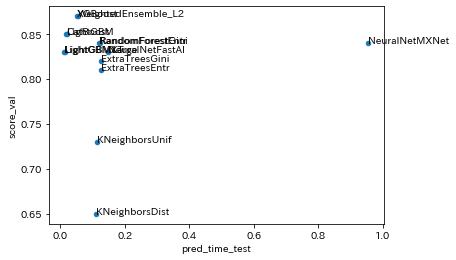

In [18]:
lb.plot.scatter('pred_time_test', 'score_val')
for _, item in lb.iterrows():
    plt.text(item.pred_time_test, item.score_val, item.model)

In [19]:
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0               XGBoost       0.87       0.006151  0.298839                0.006151           0.298839            1       True         11
1   WeightedEnsemble_L2       0.87       0.006590  0.616333                0.000439           0.317494            2       True         14
2              LightGBM       0.85       0.006666  0.220188                0.006666           0.220188            1       True          4
3              CatBoost       0.85       0.007319  0.732312                0.007319           0.732312            1       True          7
4        NeuralNetMXNet       0.84       0.101031  4.336106                0.101031           4.336106            1       True         12
5      RandomForestEntr       0.84       0.110682  0.443812                0.110682           0.443812        

/Users/ken/Developer/private/practice-automl/venv/lib/python3.7/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


In [20]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 14 features using 1000 rows with 3 shuffle sets...
	2.6s	= Expected runtime (0.87s per shuffle set)
	0.67s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
marital-status,0.052333,0.009609,0.005526,3,0.107394,-0.002727
education-num,0.030333,0.002517,0.001143,3,0.044754,0.015913
capital-gain,0.029333,0.012423,0.027455,3,0.100519,-0.041852
hours-per-week,0.013667,0.003786,0.012319,3,0.035361,-0.008027
age,0.012000,0.005568,0.032428,3,0.043904,-0.019904
education,0.006000,0.004000,0.060845,3,0.028920,-0.016920
native-country,0.002333,0.002082,0.095855,3,0.014262,-0.009595
relationship,0.002000,0.003606,0.219024,3,0.022660,-0.018660
workclass,0.001333,0.004041,0.312683,3,0.024491,-0.021825
sex,0.001333,0.001155,0.091752,3,0.007950,-0.005283
